<p style="font-family: Arial; font-size:3em;color:purple; font-style:bold"><br>Cuts Optimization using Extra Gradient Boosting
<br></p><br>

Over the last years, **Machine Learning** tools have been successfully applied to problems in high-energy physics. For example, for the classification of physics objects. Supervised machine learning algorithms allow for significant improvements in classification problems by taking into account observable correlations and by learning the optimal selection from examples, e.g. from Monte Carlo simulations.


# Importing the Libraries

**Numpy** is a powerful library that makes working with python more efficient, so we will import it and use it as np in the code. **Pandas** is another useful library that is built on numpy and has two great objects *series* and *dataframework*. Pandas works great for *data ingestion* and also has *data visualization* features. From **Hipe4ml** we import **TreeHandler** and with the help of this function we will import our *Analysis Tree* to our notebook.

**Matplotlib** comes handy in plotting data while the machine learning is performed by **XGBOOST**. We will import data splitter from **Scikit-learn** as *train_test_split*. **Evaluation metrics** such as *confusion matrix*, *Receiver operating characteristic (ROC)*, and *Area Under the Receiver Operating Characteristic Curve (ROC AUC)*  will be used to asses our models.

A **Confusion Matrix** $C$ is such that $C_{ij}$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$. Thus in binary classification, the count of true positives is $C_{00}$, false negatives $C_{01}$,false positives is $C_{10}$, and true neagtives is $C_{11}$.

If $ y^{'}_{i} $ is the predicted value of the $ i$-th sample and $y_{i}$ is the corresponding true value, then the fraction of correct predictions over $ n_{samples}$ is defined as 
$$
True \: positives (y,y^{'}) =  \sum_{i=1}^{n_{samples} } 1 (y^{'}_{i} = y_{i}=1)
$$ 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from scipy.stats import uniform

import weakref 

from bayes_opt import BayesianOptimization
from root_pandas import read_root


from data_cleaning import clean_df
from KFPF_lambda_cuts import KFPF_lambda_cuts
from plot_tools import AMS, preds_prob, plot_confusion_matrix

In [3]:
#To save some memory we will delete unused variables
class TestClass(object): 
    def check(self): 
        print ("object is alive!") 
    def __del__(self): 
        print ("object deleted") 

In [4]:
from concurrent.futures import ThreadPoolExecutor
executor = ThreadPoolExecutor(8)

# Importing the data
CBM has a modified version of the cern's root software and it contains the simulated setup of CBM. Normally, a model generated input file, for example a URQMD 12 AGeV, is passed through different macros. These macros represent the CBM setup and it is like taking particles and passing them through a detector. These particles are registered as hits in the setup. Then particles' tracks are reconstructed from these hits using cellular automaton and Kalman Filter mathematics.


CBM uses the **tree** format of cern root to store information. To reduce the size of these root files a modified tree file was created by the name of Analysis tree. This Analysis tree file contains most of the information that we need for physics analysis. 

In this example, we download three Analysis Trees. The first one contains mostly background candidates for lambda i.e. protons and pions which do not come from a lambda. The second file contains mostly signal candidates of lamba i.e. it contains protons and pions which come from a lambda decay. The third one contains 10k events generated using URQMD generator with 12 AGeV energy.

In [5]:
# We import three root files into our jupyter notebook
signal = read_root('/home/shahid/cbmsoft/Data/PFSimplePlainTreeSignal.root','PlainTree')
# We only select lambda candidates
sgnal = signal[(signal['LambdaCandidates_is_signal']==1) & (signal['LambdaCandidates_mass']>1.108)
               & (signal['LambdaCandidates_mass']<1.1227)]

# Similarly for the background
background = read_root('/home/shahid/cbmsoft/Data/PFSimplePlainTreeBackground.root','PlainTree')
bg = background[(background['LambdaCandidates_is_signal'] == 0)
                & ((background['LambdaCandidates_mass'] > 1.07)
                & (background['LambdaCandidates_mass'] < 1.108) | (background['LambdaCandidates_mass']>1.1227) 
                   & (background['LambdaCandidates_mass'] < 2.00))]


del signal
del background

# Parallel processing

In [6]:
import uproot
file = uproot.open('/home/shahid/cbmsoft/Data/10k_events_PFSimplePlainTree.root:PlainTree', library='pd', decompression_executor=executor,
                                  interpretation_executor=executor).arrays(library='np',decompression_executor=executor,
                                  interpretation_executor=executor)
import gc
gc.collect()

29532

In [7]:
df_original= pd.DataFrame(data=file)
del file

## Renaming the columns

In [8]:
#The labels of the columns in the df data frame are having the prefix LambdaCandidates_ so we rename them
new_labels= ['chi2geo', 'chi2primneg', 'chi2primpos', 'chi2topo', 'cosineneg',
       'cosinepos', 'cosinetopo', 'distance', 'eta', 'l', 'ldl',
       'mass', 'p', 'pT', 'phi', 'px', 'py', 'pz', 'rapidity',
             'x', 'y', 'z', 'daughter1id', 'daughter2id', 'isfrompv', 'pid', 'issignal']

df_original.columns=new_labels
sgnal.columns = new_labels
bg.columns = new_labels

#Let's see how the dataframe object df looks like
#df_original

The above data frame object has some columns/features and for them at the very last column the true Monte Carlos information is available. This MC information tells us whether this reconstructed particle was originally produced as a decaying particle or not. So a value of 1 means that it is a true candidate and 0 means that it is not.

# Data Cleaning
Sometimes a data set contains entries which do not make sense. For example, infinite values or NaN entries. We clean the data by removing these entries. Ofcourse, we lose some data points but these outliers sometimes cause problems when we perform analysis. 

Since our experiment is a fixed target experiment so there are certain constraints which have to be applied on the data as well.

In [9]:
#Creating a new data frame and saving the results in it after cleaning of the original dfs
#Also keeping the original one
bcknd = clean_df(bg)
signal = clean_df(sgnal)

del bg
del sgnal
gc.collect()

0

In [10]:
df_clean = clean_df(df_original)
del df_original
gc.collect()

20

# Selecting Background and Signal
Our sample contains a lot of background (2178718) and somewhat signal candidates (36203). For analysis we will use a signal set of 4000 candidates and a background set of 12000 candidates. The background and signal candidates will be selected by using MC information.

In [11]:
# We randomly choose our signal set of 4000 candidates
signal_selected= signal.sample(n=90000)

#background = 3 times the signal is also done randomly
background_selected = bcknd

del signal
del bcknd

In [12]:
#Let's combine signal and background
dfs = [signal_selected, background_selected]
df_scaled = pd.concat(dfs)

In [13]:
# Let's shuffle the rows randomly
df_scaled = df_scaled.sample(frac=1)
del dfs
# Let's take a look at the top 10 entries of the df
df_scaled.iloc[0:10,:]

,chi2geo,chi2primneg,chi2primpos,chi2topo,cosineneg,cosinepos,cosinetopo,distance,eta,l,...,pz,rapidity,x,y,z,daughter1id,daughter2id,isfrompv,pid,issignal
361826,0.298643,0.679810,3.120182,1.177294,0.873419,0.992219,0.966529,0.008184,2.103767,0.010410,...,3.807898,1.511015,-0.016614,0.054416,0.017070,49.0,14.0,0.0,3122.0,0.0
224903,4.284091,8.207214,3.715490,2.806512,0.990915,0.999608,0.999654,0.165819,2.069355,0.878264,...,5.119421,1.803228,0.196180,0.054722,0.847857,321.0,10.0,0.0,3122.0,0.0
98672,0.682848,2.603848,0.226418,0.892152,0.964765,0.968333,0.741833,0.005195,2.569117,0.005062,...,2.073017,1.162977,-0.195985,-0.114180,0.007740,108.0,140.0,0.0,3122.0,0.0
682100,0.549086,1.924319,0.362402,0.252225,0.981590,0.999324,0.999719,0.002073,2.573461,0.014435,...,11.121903,2.309042,-0.051592,0.131723,0.005712,31.0,20.0,0.0,3122.0,0.0
396421,2.116893,6388.867188,6924.685547,1.661030,0.996181,0.999620,0.999998,0.186385,2.231897,21.483059,...,2.139102,1.335793,-3.356097,-2.860824,20.990232,313.0,86.0,0.0,3122.0,1.0
678000,14.814519,2.896591,29.143909,10.186183,0.993471,0.998163,0.953590,0.055299,2.115159,0.050425,...,2.746035,1.443417,0.004225,0.036701,0.044554,41.0,40.0,0.0,3122.0,0.0
846548,1.998198,729231.500000,73935.742188,0.967239,0.982498,0.999408,1.000000,0.000808,2.017790,12.255327,...,3.345432,1.581256,0.019619,3.048669,11.823698,78.0,137.0,0.0,3122.0,1.0
916751,0.375758,66241.640625,59536.531250,6.931527,0.995788,0.999813,0.999997,0.028347,2.241882,61.558498,...,5.948519,1.967243,3.837644,12.103272,60.213989,309.0,208.0,0.0,3122.0,1.0
666881,6.793303,92800.875000,11731.187500,3.838992,0.998720,0.999875,1.000000,0.016427,2.425477,12.123299,...,5.028485,1.967127,1.548621,-1.584114,11.937194,151.0,59.0,0.0,3122.0,1.0
467454,0.426772,0.079990,5.012991,1.170628,0.988233,0.997369,0.918642,0.005908,2.510002,0.009423,...,2.611936,1.472612,-0.088490,0.125170,0.005366,51.0,150.0,0.0,3122.0,0.0


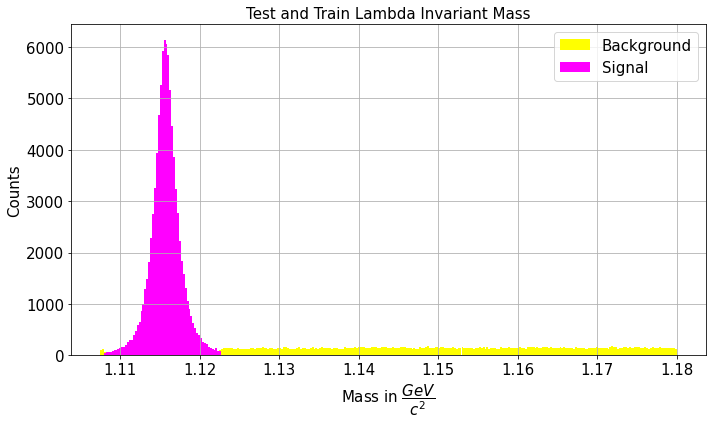

In [14]:
range1 = (1.1075, 1.18)
fig, axs = plt.subplots(figsize=(10, 6))
#df_scaled['mass'].plot.hist(bins = 300, range=range1,grid=True,sharey=True)
df_scaled['mass'].plot.hist(bins = 300, facecolor='yellow',grid=True,range=range1)
signal_selected['mass'].plot.hist(bins = 300, facecolor='magenta',grid=True, range=range1)
plt.ylabel("Counts", fontsize=15)
plt.xlabel("Mass in $\dfrac{GeV}{c^2}$", fontsize= 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Test and Train Lambda Invariant Mass', fontsize = 15)
plt.legend(('Background', 'Signal'), fontsize = 15)
fig.tight_layout()
fig.savefig("signal_bac_invmass_MC.png")

# Creating Train and Test sets
To make machine learning algorithms more efficient on unseen data we divide our data into two sets. One set is for training the algorithm and the other is for testing the algorithm. If we don't do this then the algorithm can overfit and we will not capture the general trends in the data. 

In [15]:
# The following columns will be used to predict whether a reconstructed candidate is a lambda particle or not
cuts = [ 'chi2primneg', 'chi2primpos', 'ldl', 'distance', 'chi2geo']


x = df_scaled[cuts].copy()

In [16]:
# The MC information is saved in this y variable
y =pd.DataFrame(df_scaled['issignal'], dtype='int')

## Whole set

In [17]:
# The following columns will be used to predict whether a reconstructed candidate is a lambda particle or not
x_whole = df_clean[cuts].copy()
# The MC information is saved in this y variable
y_whole = pd.DataFrame(df_clean['issignal'], dtype='int')

# KFPF

In [18]:
#returns a new df 
new_check_set=KFPF_lambda_cuts(df_clean)

<p style="font-family: Arial; font-size:3em;color:purple; font-style:bold"><br>XGB Boost 
<br></p><br>

## Bayesian
In order to find the best parameters of XGB for our data we use Bayesian optimization. Grid search and and random search could also do the same job but bayesian is more time efficient.

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=324)

In [20]:
dtrain = xgb.DMatrix(x_train, label = y_train)
dtest = xgb.DMatrix(x_whole, label = y_whole)
dtest1=xgb.DMatrix(x_test, label = y_test)

### Hyper parameters

*subsample* [default=1]
Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration.
range: (0,1]

*eta* [default=0.3, alias: learning_rate]
Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
range: [0,1]


*gamma* [default=0, alias: min_split_loss]
Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
range: [0,∞]


*alpha* [default=0, alias: reg_alpha]
L1 regularization term on weights. Increasing this value will make model more conservative.

*Lasso Regression* (Least Absolute Shrinkage and Selection Operator) adds “absolute value of magnitude” of coefficient as penalty term to the loss function.

In [21]:
#Bayesian Optimization function for xgboost
#specify the parameters you want to tune as keyword arguments
def bo_tune_xgb(max_depth, gamma, alpha, n_estimators ,learning_rate):
    params = {'max_depth': int(max_depth),
              'gamma': gamma,
              'alpha':alpha,
              'n_estimators': n_estimators,
              'learning_rate':learning_rate,
              'subsample': 0.8,
              'eta': 0.1,
              'eval_metric': 'auc', 'nthread' : 7}
    cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5)
    return  cv_result['test-auc-mean'].iloc[-1]



In [22]:
#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (4, 10),
                                             'gamma': (0, 1),
                                            'alpha': (2,20),
                                             'learning_rate':(0,1),
                                             'n_estimators':(100,500)
                                            })

In [23]:
#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an #acquisition function of expected improvement
xgb_bo.maximize(n_iter=15, init_points=8, acq='ei')
#0.9952

|   iter    |  target   |   alpha   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------------------
|  1        |  0.9941   |  19.63    |  0.08081  |  0.6671   |  6.746    |  486.6    |
|  2        |  0.9946   |  2.318    |  0.7957   |  0.4471   |  8.039    |  460.4    |
|  3        |  0.9932   |  14.32    |  0.01131  |  0.8625   |  9.906    |  171.0    |
|  4        |  0.9938   |  15.13    |  0.5368   |  0.7809   |  9.96     |  357.0    |
|  5        |  0.9936   |  17.93    |  0.3248   |  0.8456   |  7.481    |  337.4    |
|  6        |  0.9941   |  13.79    |  0.9685   |  0.5395   |  5.275    |  259.7    |
|  7        |  0.9948   |  8.193    |  0.5861   |  0.3232   |  7.098    |  375.4    |
|  8        |  0.9945   |  2.852    |  0.9419   |  0.144    |  4.916    |  241.0    |
|  9        |  0.9949   |  7.136    |  0.7601   |  0.3411   |  7.799    |  376.2    |
|  10       |  0.9935   |  2.488    |  0.8556   |  0.7

KeyboardInterrupt: 

# XGB models

In [24]:
max_param = xgb_bo.max['params']
param= {'alpha': max_param['alpha'], 'gamma': max_param['gamma'], 'learning_rate': max_param['learning_rate'], 'max_depth': int(round(max_param['max_depth'],0)), 'n_estimators': int(round(max_param['n_estimators'],0)), 'objective': 'binary:logistic'}

In [25]:
bst = xgb.train(param, dtrain)

[15:03:03] WARNING: /workspace/src/learner.cc:328: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [26]:
bst1= bst.predict(dtrain)

In [27]:
bst_test = pd.DataFrame(data=bst.predict(dtest1),  columns=["xgb_preds"])
y_test=y_test.set_index(np.arange(0,bst_test.shape[0]))
bst_test['issignal']=y_test['issignal']

/home/shahid/cbmsoft/Cut_optimization/uncut_data/Project/plot_tools.py:10: RuntimeWarning: invalid value encountered in true_divide
  S0 = sqrt(2 * ((tpr + fpr) * log((1 + tpr/fpr)) - tpr))
/home/shahid/cbmsoft/Cut_optimization/uncut_data/Project/plot_tools.py:17: RuntimeWarning: invalid value encountered in true_divide
  S01 = sqrt(2 * ((tpr1 + fpr1) * log((1 + tpr1/fpr1)) - tpr1))


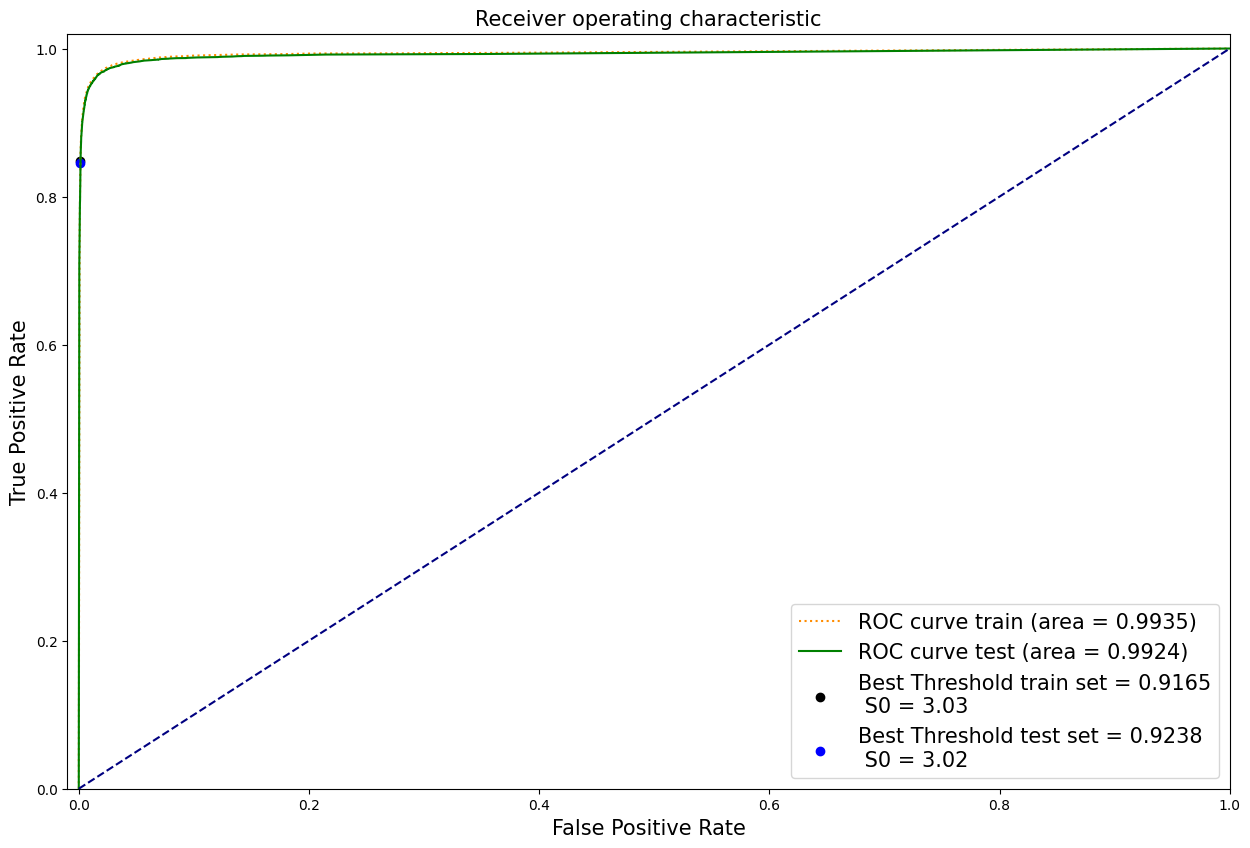

In [28]:
train_best, test_best = AMS(y_train, bst1,y_test, bst_test['xgb_preds'])

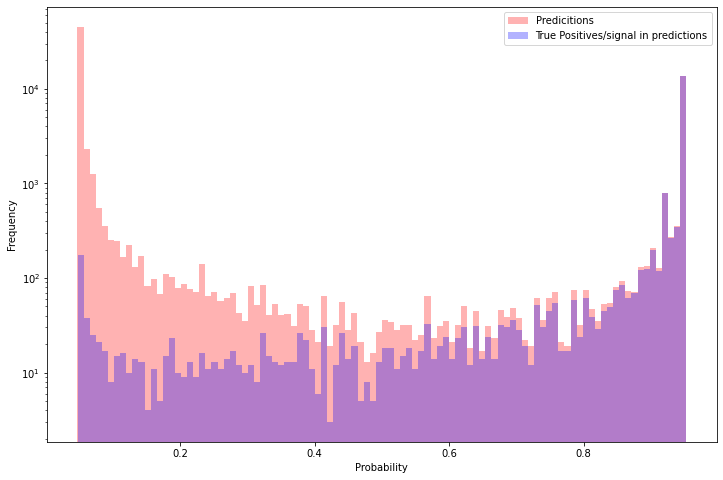

In [29]:
#The first argument should be a data frame, the second a column in it, in the form 'preds'
preds_prob(bst_test,'xgb_preds', 'issignal')

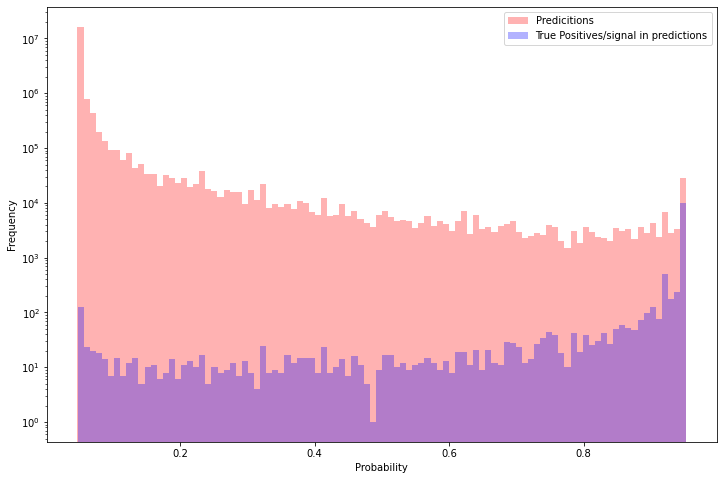

In [30]:
#Applying XGB on the 10k events data-set
df_clean['xgb_preds'] = bst.predict(dtest)
preds_prob(df_clean,'xgb_preds', 'issignal')

## Already working model

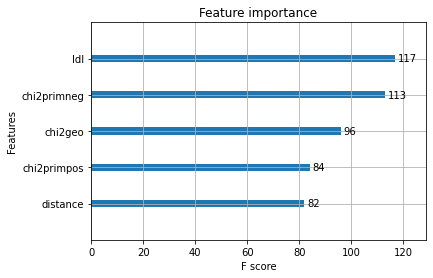

In [31]:
ax = xgb.plot_importance(bst)
plt.rcParams['figure.figsize'] = [8, 4]
plt.show()
ax.figure.tight_layout() 
ax.figure.savefig("hits.png")

In [32]:
def cut_visualization(cut, range1=(1.105, 1.19), bins1= 300 ):
    mask1 = df_clean['xgb_preds']>cut
    df3=df_clean[mask1]
    
    fig, ax2 = plt.subplots(figsize=(15, 10), dpi = 200)
    color = 'tab:blue'
    ax2.hist(df_clean['mass'],bins = bins1, range=range1, facecolor='blue',alpha = 0.35, label='before selection')
    ax2.set_ylabel('Counts', fontsize = 15, color=color)
    ax2.set_xlabel('Mass in GeV', fontsize = 15)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend( fontsize = 15, loc='upper left')
    
    color = 'tab:red'
    ax1 = ax2.twinx()
    ax1.hist(df3['mass'], bins = bins1, range=range1, facecolor='red',alpha = 0.35, label='Machine learning (XGB)')
    ax1.set_xlabel('Mass in GeV', fontsize = 15)
    ax1.set_ylabel('Counts ', fontsize = 15, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend( fontsize = 15,loc='upper right' )
    
    
    
    plt.title("The sample's Invariant Mass with XGB (with a cut > "+str(cut)+')', fontsize = 15)
    fig.tight_layout()
    #fig.savefig("whole_sample_invmass_with_ML.png")

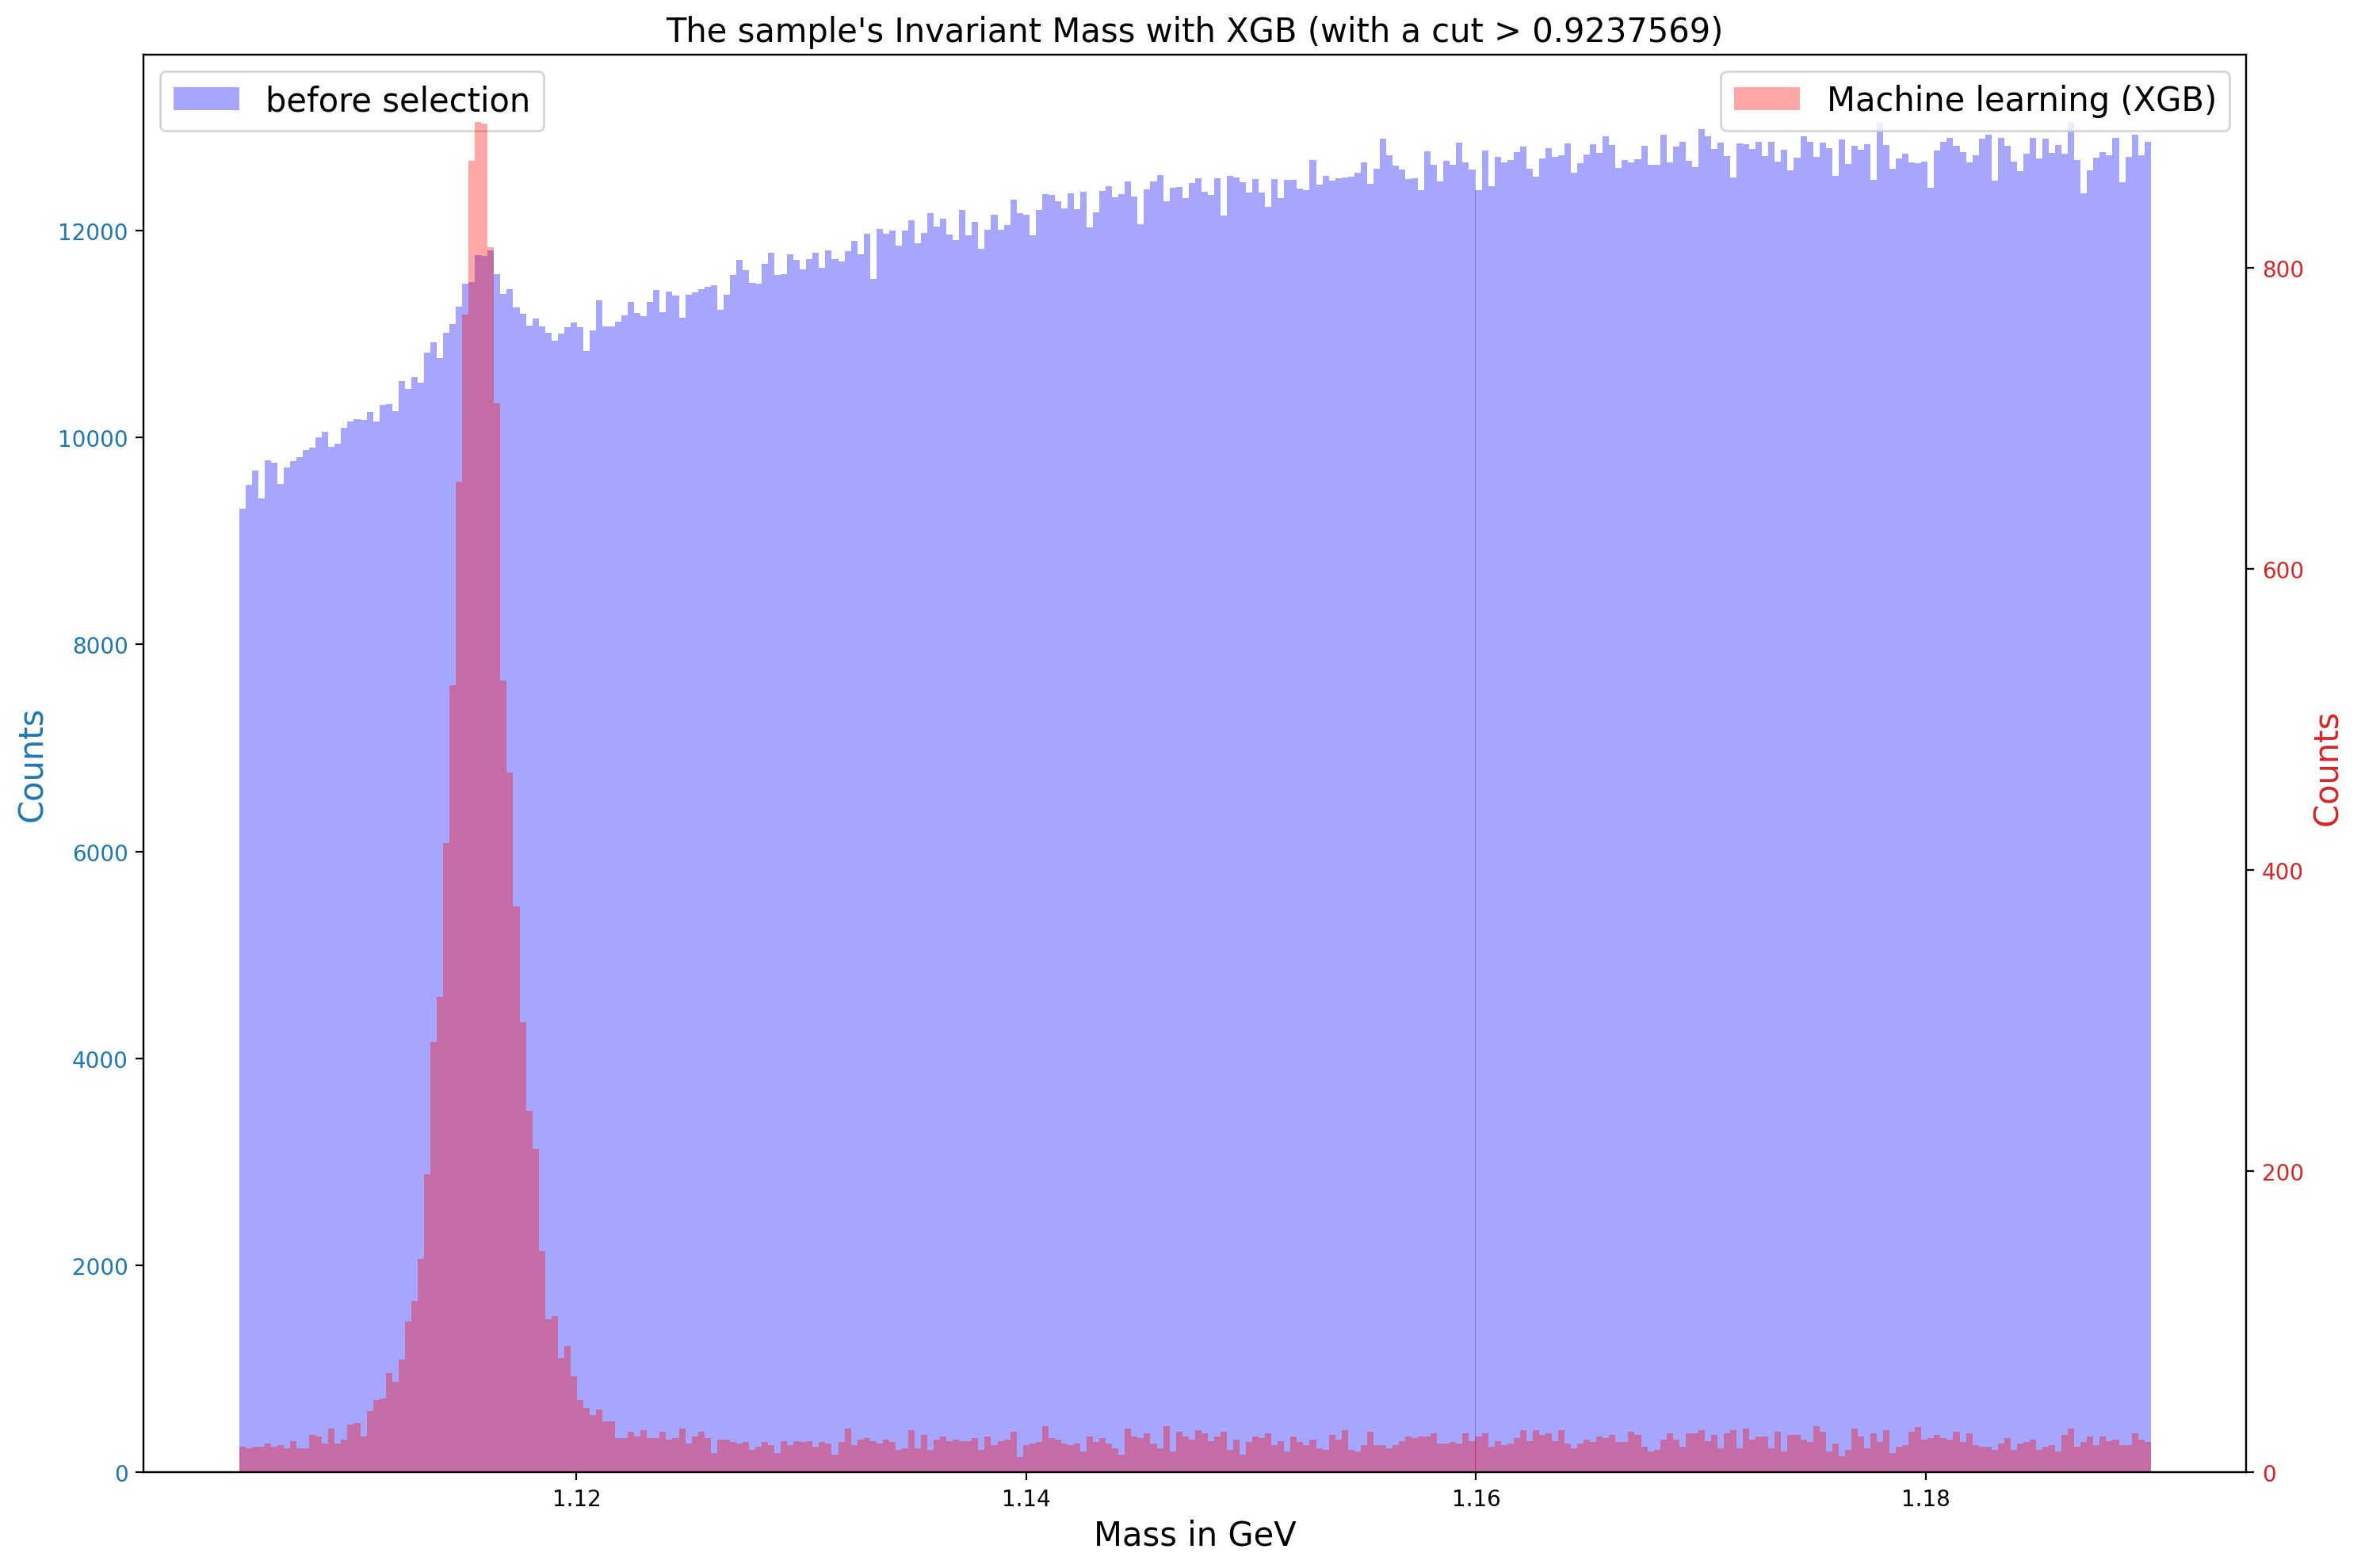

In [33]:
cut_visualization(test_best)

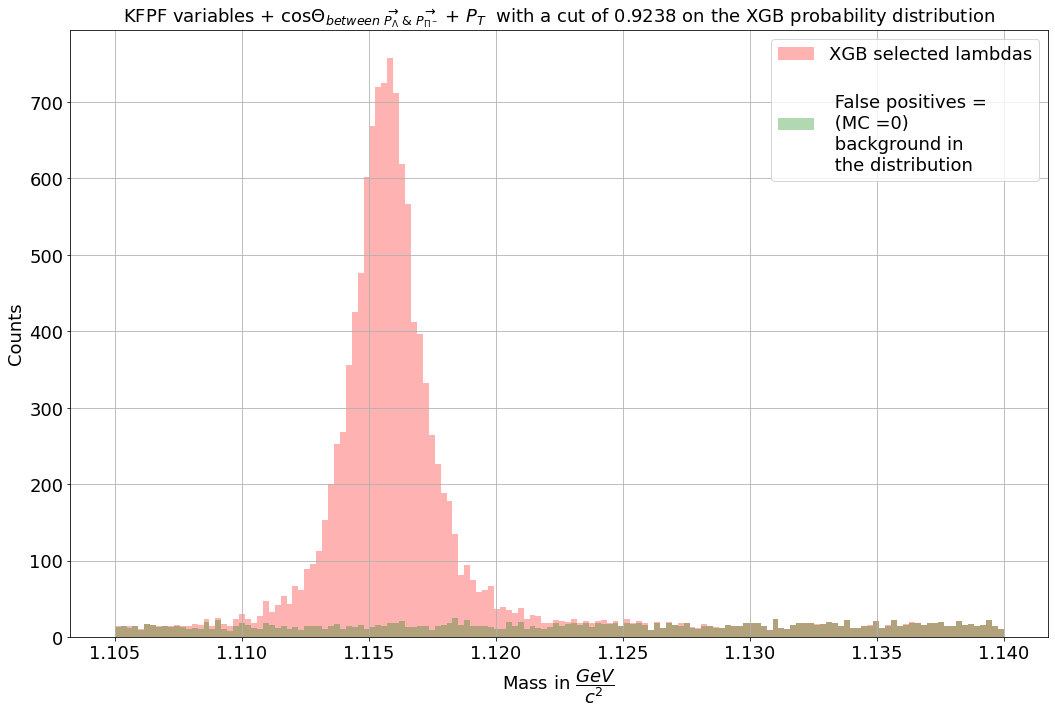

In [34]:
cut3 = test_best
mask1 = df_clean['xgb_preds']>test_best
df3=df_clean[mask1]
fig, axs = plt.subplots(figsize=(15, 10))

range1= (1.105, 1.14)
bins1 = 150

#xgb

df3_new = df3[df3['issignal']==1]
df3_new1 = df3[df3['issignal']==0]
df3['mass'].plot.hist(bins = bins1, range=range1, facecolor='red',alpha = 0.3,grid=True,sharey=True)
#df3_new['mass'].plot.hist(bins = 300, range=range1,facecolor='blue',alpha = 0.3,grid=True,sharey=True)
df3_new1['mass'].plot.hist(bins = bins1, range=range1,facecolor='green',alpha = 0.3,grid=True,sharey=True)
plt.legend(('XGB selected lambdas','\n False positives = \n (MC =0)\n background in \n the distribution' ), fontsize = 18, loc='upper right')
#plt.rcParams["legend.loc"] = 'upper right'
plt.title("KFPF variables + cos$\Theta_{between \ \overrightarrow{P_\Lambda} \  & \ \overrightarrow{P_{\Pi^-}}}$ + $P_T$  with a cut of %.4f "%cut3 +"on the XGB probability distribution", fontsize = 18)
plt.xlabel("Mass in $\dfrac{GeV}{c^2}$", fontsize = 18)
plt.ylabel("Counts", fontsize = 18)
axs.tick_params(labelsize=18)
fig.tight_layout()
fig.savefig("whole_sample_invmass_with_ML.png")

## Confusion Matrix

By definition a confusion matrix $C$ is such that $C_{i, j}$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$.

Thus in binary classification, the count of true positives is $C_{0,0}$, false positives is $C_{1,0}$, true negatives is $C_{1,1}$ and false negatives is $C_{0,1}$.

The following function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`.

Confusion matrix, without normalization
[[   10491     2407]
 [   25736 19123891]]


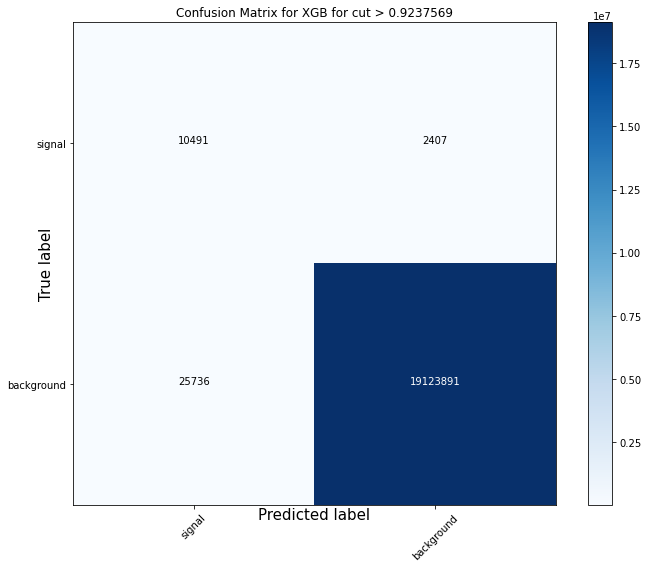

In [35]:
cut1 = test_best
df_clean['xgb_preds1'] = ((df_clean['xgb_preds']>cut1)*1)
cnf_matrix = confusion_matrix(y_whole, df_clean['xgb_preds1'], labels=[1,0])
np.set_printoptions(precision=2)
fig, axs = plt.subplots(figsize=(10, 8))
axs.yaxis.set_label_coords(-0.04,.5)
axs.xaxis.set_label_coords(0.5,-.005)
plot_confusion_matrix(cnf_matrix, classes=['signal','background'], title='Confusion Matrix for XGB for cut > '+str(cut1))
plt.savefig('confusion_matrix_extreme_gradient_boosting_whole_data.png')

<p style="font-family: Arial; font-size:3em;color:purple; font-style:bold"><br>Tree visualization
<br></p><br>

In [ ]:
#fig, ax1 = plt.subplots(figsize=(15, 10), dpi = 200)
xgb.plot_tree(bst,num_trees=10)
plt.rcParams['figure.figsize'] = [20, 40]
plt.rcParams['figure.dpi']=200
plt.show()

In [ ]:
xgb.to_graphviz(xg_reg, fmap='', num_trees=0, rankdir=None, yes_color=None, no_color=None, condition_node_params=None, leaf_node_params=None)

# Cut visualization

In [ ]:
cut3 = S0_best_threshold
mask1 = df_clean['xgb_preds']>cut3
df3_base_cospos=df_clean[mask1]

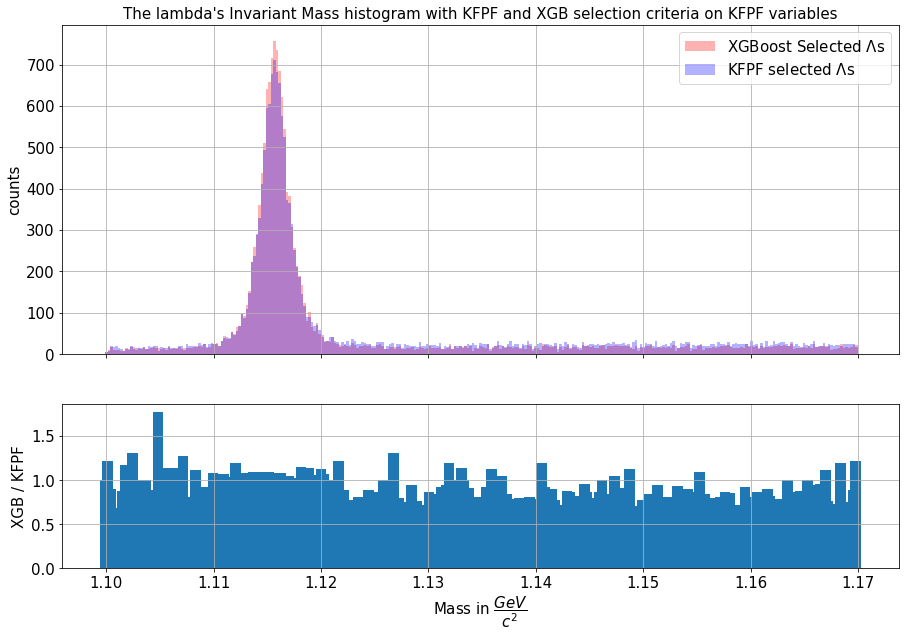

In [37]:
from matplotlib import gridspec

range1= (1.0999, 1.17)


fig, axs = plt.subplots(2, 1,figsize=(15,10), sharex=True,  gridspec_kw={'width_ratios': [10],
                           'height_ratios': [8,4]})

ns, bins, patches=axs[0].hist((df3_base['mass']),bins = 300, range=range1, facecolor='red',alpha = 0.3)
ns1, bins1, patches1=axs[0].hist((new_check_set['mass']),bins = 300, range=range1,facecolor='blue',alpha = 0.3)
#plt.xlabel("Mass in GeV", fontsize = 15)
axs[0].set_ylabel("counts", fontsize = 15)
#axs[0].grid()
axs[0].legend(('XGBoost Selected $\Lambda$s','KFPF selected $\Lambda$s'), fontsize = 15, loc='upper right')

#plt.rcParams["legend.loc"] = 'upper right'
axs[0].set_title("The lambda's Invariant Mass histogram with KFPF and XGB selection criteria on KFPF variables", fontsize = 15)
axs[0].grid()
axs[0].tick_params(axis='both', which='major', labelsize=15)
#fig.savefig("whole_sample_invmass_with_ML.png")


hist1, bin_edges1 = np.histogram(df3_base['mass'],range=(1.09, 1.17), bins=300)
hist2, bin_edges2 = np.histogram(new_check_set['mass'],range=(1.09, 1.17), bins=300)

#makes sense to have only positive values 
diff = (hist1 - hist2)
axs[1].bar(bins[:-1],     # this is what makes it comparable
        ns / ns1, # maybe check for div-by-zero!
        width=0.001)
plt.xlabel("Mass in $\dfrac{GeV}{c^2}$", fontsize = 15)
axs[1].set_ylabel("XGB / KFPF", fontsize = 15)
axs[1].grid()
axs[1].tick_params(axis='both', which='major', labelsize=15)

plt.show()
fig.tight_layout()
fig.savefig("whole_sample_invmass_with_ML.png")

In [36]:
cut3 = test_best
mask1 = df_clean['xgb_preds']>cut3
df3_base=df_clean[mask1]

In [ ]:
from matplotlib import gridspec

range1= (1.09, 1.17)
bin1 = 200


fig, axs = plt.subplots(2, 1,figsize=(15,10), sharex=True,  gridspec_kw={'width_ratios': [10],
                           'height_ratios': [8,4]})

ns, bins, patches=axs[0].hist((df3_base_cospos['mass']),bins = bin1, range=range1, facecolor='red',alpha = 0.3)
ns1, bins1, patches1=axs[0].hist((df3_base['mass']),bins = bin1, range=range1,facecolor='blue',alpha = 0.3)
#plt.xlabel("Mass in GeV", fontsize = 15)
axs[0].set_ylabel("counts", fontsize = 15)
#axs[0].grid()
axs[0].legend(('XGB base+ cos$\Theta_{between \ \overrightarrow{P_\Lambda} \  & \ \overrightarrow{P_{proton}}}$ Selected $\Lambda$s','XGB base selected $\Lambda$s'), fontsize = 15, loc='upper right')

#plt.rcParams["legend.loc"] = 'upper right'
axs[0].set_title("The lambda's Invariant Mass histogram with XGB base and XGB base+ cos$\Theta_{between \ \overrightarrow{P_\Lambda} \  & \ \overrightarrow{P_{proton}}}$ selection criteria", fontsize = 15)
axs[0].grid()
axs[0].tick_params(axis='both', which='major', labelsize=15)
#fig.savefig("whole_sample_invmass_with_ML.png")


hist1, bin_edges1 = np.histogram(df3_base_cospos['mass'],range=range1, bins=bin1)
hist2, bin_edges2 = np.histogram(df3_base['mass'],range=range1, bins=bin1)

#makes sense to have only positive values 
diff = (hist1 - hist2)
axs[1].bar(bins[:-1],     # this is what makes it comparable
        ns / ns1, # maybe check for div-by-zero!
        width=0.001)
plt.xlabel("Mass in $\dfrac{GeV}{c^2}$", fontsize = 15)
axs[1].set_ylabel("XGB base+cospos / XGB base", fontsize = 15)
axs[1].grid()
axs[1].tick_params(axis='both', which='major', labelsize=15)

plt.show()
fig.tight_layout()
fig.savefig("whole_sample_invmass_with_ML.png")